In [1]:
import matplotlib.pyplot as plt
import pylab
import math
import copy
import os
import time
import warnings
import numpy as np
from sklearn.model_selection import train_test_split


from IPython.display import clear_output

import sys
sys.path.append("C:\\Users\\artur\\Desktop\\QAE")

from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
from qae_utils.Charts import multi_plot_flat_ts, meas_plot
from qae_utils.Tools import draw_circuit
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg
from qae_utils.Window import ts_calc_noise, ts_add_noise
from qae_utils.Files import read_pickle_file
from qae_utils.Files import write_pickle_file

In [2]:
# Load the Mackey-Glass data
DATA_PATH = 'aintern/data'
DATA_NAME = 'mackey_glass'

data_folders = [f for f in os.listdir(DATA_PATH) if f.startswith(DATA_NAME)]
    
data_folder = data_folders[0]

X = read_ts_file(f'{DATA_PATH}/{data_folder}/x_org.arr')
y = read_ts_file(f'{DATA_PATH}/{data_folder}/y_org.arr')
info = read_json_file(f'{DATA_PATH}/{data_folder}/info.json')

In [3]:
### Libraries used in QAE development

# PennyLane imports
import pennylane as qml
from pennylane import numpy as pnp

In [4]:
### Quantum simulator
sim = 'default.qubit' # default.qubit lightning.qubit lightning.gpu

In [5]:
# Half-QAE Architecture Parameters
n_qubits = 4     # Total qubits
n_latent = 2     
n_trash = n_qubits - n_latent 

print(f"QAE Architecture:")
print(f"- Total qubits: {n_qubits}")
print(f"- Latent space: {n_latent} qubits")  
print(f"- Trash space: {n_trash} qubits")

# Create quantum device
dev = qml.device('default.qubit', wires=n_qubits)

QAE Architecture:
- Total qubits: 4
- Latent space: 2 qubits
- Trash space: 2 qubits


In [6]:
# Define the Half-QAE Circuit
def encoder_ansatz(params, x):
    # 1. Simple angle encoding
    for i, val in enumerate(x[:n_qubits]):
        qml.RY(val * np.pi, wires=i)
    
    # 2. Simple variational layers
    n_layers = len(params) // (n_qubits * 3)
    for layer in range(n_layers):
        for i in range(n_qubits):
            idx = layer * n_qubits * 3 + i * 3
            qml.RX(params[idx], wires=i)
            qml.RY(params[idx + 1], wires=i)
            qml.RZ(params[idx + 2], wires=i)
        
        # Simple entanglement
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])

def decoder_ansatz(params,x):
        # 1. Simple angle encoding
    for i, val in enumerate(x[:n_qubits]):
        qml.RY(val * np.pi, wires=i)
    n_layers = len(params) // (n_qubits * 3)
    
    for layer in range(n_layers):
        # Reverse entanglement
        qml.CNOT(wires=[n_qubits - 1, 0])
        for i in range(n_qubits - 2, -1, -1):
            qml.CNOT(wires=[i + 1, i])
        
        # Rotations
        for i in range(n_qubits):
            idx = layer * n_qubits * 3 + i * 3
            qml.RZ(params[idx + 2], wires=i)
            qml.RY(params[idx + 1], wires=i)
            qml.RX(params[idx], wires=i)


In [7]:
@qml.qnode(dev, diff_method="backprop")
def decoder_circuit(dec_params, x):
    decoder_ansatz(dec_params, x)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


In [8]:
# Prepare training data with sliding windows
window_size = n_qubits
stride = 1

X_windows = []
for i in range(0, len(y) - window_size + 1, stride):
    window = y[i:i + window_size]
    X_windows.append(window)

X_windows = np.array(X_windows)

# Split into train/validation/test
X_temp, X_test = train_test_split(X_windows, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 of total


In [9]:
#TRAINING SETTINGS
n_epochs = 100
batch_size = 8  
learning_rate = 0.01
n_layers = 2

np.random.seed(42)
init_scale = 0.0
enc_param_shape = n_layers * n_qubits * 3
dec_param_shape = n_layers * n_qubits * 3

enc_params = pnp.array(np.random.uniform(-init_scale, init_scale, enc_param_shape), requires_grad=True)
dec_params = pnp.array(np.random.uniform(-init_scale, init_scale, dec_param_shape), requires_grad=True)

In [10]:
# Funkcja kosztu dla samego dekodera
def decoder_only_cost(dec_params, X_batch):
    total_cost = 0.0
    for x in X_batch:
        output_raw = decoder_circuit(dec_params, x)
        output_scaled = []
        for o in output_raw:
            o_val = float(o) if hasattr(o, 'numpy') else o
            scaled = (o_val + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low']
            output_scaled.append(scaled)
        output_scaled = pnp.array(output_scaled)
        x_tensor = pnp.array(x)
        mse = pnp.mean((x_tensor - output_scaled)**2)
        total_cost += mse
    return total_cost / len(X_batch)

In [11]:
# Pętla treningowa dla samego dekodera
def train_decoder_only(dec_params_init, n_epochs=50, batch_size=8, lr=0.01):
    params = pnp.array(dec_params_init, requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=lr)
    history = []
    for epoch in range(n_epochs):
        idx = np.random.permutation(len(X_train))
        cost_epoch = 0.0
        n_batches = 0
        for i in range(0, len(X_train), batch_size):
            batch_idx = idx[i:i+batch_size]
            Xb = X_train[batch_idx]
            params, cost = opt.step_and_cost(lambda p: decoder_only_cost(p, Xb), params)
            cost_epoch += float(cost)
            n_batches += 1
        avg_cost = cost_epoch / n_batches
        history.append(avg_cost)
        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d}: Decoder cost = {avg_cost:.6f}")
    print("Trening dekodera zakończony!")
    return params, history

# Inicjalizacja i trening
dec_params_init = pnp.array(np.random.uniform(-0.01, 0.01, dec_param_shape), requires_grad=True)
dec_params_trained, decoder_train_history = train_decoder_only(dec_params_init, n_epochs=100, batch_size=8, lr=0.01)

Epoch   0: Decoder cost = 0.039695
Epoch  10: Decoder cost = 0.012724
Epoch  20: Decoder cost = 0.006238
Epoch  30: Decoder cost = 0.005340
Epoch  40: Decoder cost = 0.004744
Epoch  50: Decoder cost = 0.004477
Epoch  60: Decoder cost = 0.003693
Epoch  70: Decoder cost = 0.004723
Epoch  80: Decoder cost = 0.005160
Epoch  90: Decoder cost = 0.003318
Trening dekodera zakończony!


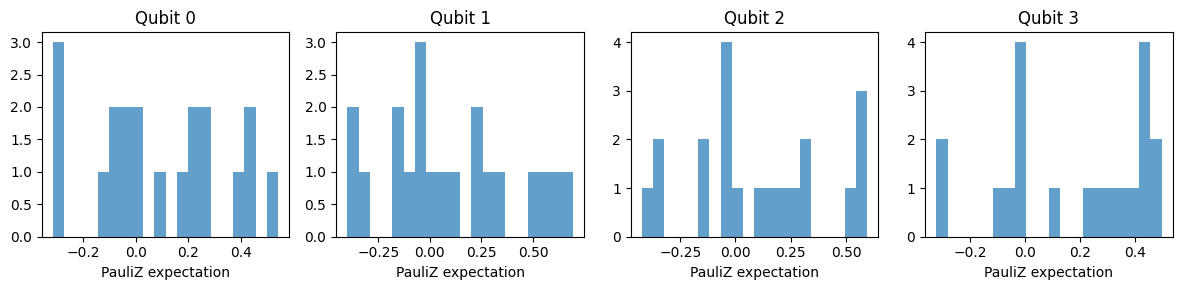

In [12]:
import matplotlib.pyplot as plt

outputs_all = [decoder_circuit(dec_params_trained, x) for x in X_test[:100]]
outputs_all = np.array(outputs_all)

plt.figure(figsize=(12, 3))
for i in range(outputs_all.shape[1]):
    plt.subplot(1, outputs_all.shape[1], i+1)
    plt.hist(outputs_all[:, i], bins=20, alpha=0.7)
    plt.title(f'Qubit {i}')
    plt.xlabel('PauliZ expectation')
plt.tight_layout()
plt.show()

## STAGE 2

In [13]:
### Swap test
#   data_wires: wires with data to be tested
#   comp_wires: wires with data to be compared against
#   test_wire: measured wire
#def swap_test(data_wires, comp_wires, test_wire):
#    n_wires = range(len(data_wires)+len(comp_wires) + 1)
#    n_aux_wire = len(data_wires)+len(comp_wires)
    
#    qml.Hadamard(test_wire)
#    for i in range(len(data_wires)):
#        qml.CSWAP([test_wire, data_wires[i], comp_wires[i]])    
#    qml.Hadamard(test_wire)

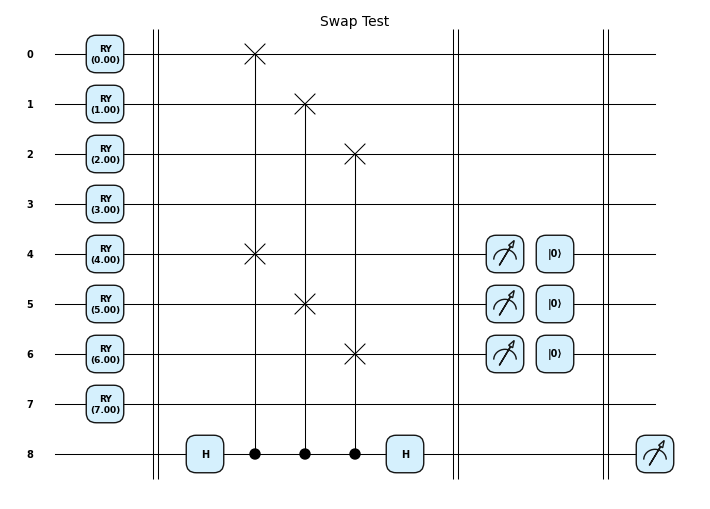

In [ ]:
### Swap test wrapper
#def test_swap_test(data_wires, comp_wires, test_wire):
#    for w in range(0, test_wire): qml.RY(w, w)
#    qml.Barrier(data_wires+comp_wires+[test_wire])
#    swap_test(data_wires, comp_wires, test_wire)
#    qml.Barrier(data_wires+comp_wires+[test_wire])
#    for w in comp_wires: qml.measure(w, reset=True)
#    qml.Barrier(data_wires+comp_wires+[test_wire])
#    return qml.probs(wires=test_wire)
    
### Testing swap test
#shots = 1
#n_wires = 9
#data_wires = [0, 1, 2]
#trash_wires = [4, 5, 6]
#aux_wire = 8

#dev_shots = qml.device('lightning.qubit', wires=n_wires, shots=shots)

#swap_qc = qml.QNode(test_swap_test, dev_shots, interface='torch')
#draw_circuit(swap_qc, scale=0.5, title='Swap Test', level='gradient') \
#    (data_wires, trash_wires, aux_wire) # expansion_strategy='device'/'gradient'

In [ ]:
# @qml.qnode(dev, diff_method="backprop")
# def sidekick_encoder(enc_params, x):
#     encoder_ansatz(enc_params, x)
#     return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
# @qml.qnode(dev, diff_method="backprop")
# def sidekick_decoder(dec_params, x):
#     decoder_ansatz(dec_params, x)
#     return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
# latent_indices = list(range(n_latent))  # np. [0, 1]

# def get_latents(model, params, x, indices):
#     outputs = model(params, x)
#     return [outputs[i] for i in indices]

In [ ]:
# def test_swap(enc_params, dec_params, x_noisy, x_clean, indices):
#     n = len(indices)
#     dev_swap = qml.device('default.qubit', wires=2*n+1, shots=100)
#     @qml.qnode(dev_swap)
#     def circuit(enc_params, dec_params, x_noisy, x_clean):
#         # Przygotuj latent encoder na pierwszych n kubitach
#         qml.templates.AngleEmbedding(x_noisy[:n], wires=range(n))
#         encoder_ansatz(enc_params, x_noisy)
#         # Przygotuj latent decoder na kolejnych n kubitach
#         qml.templates.AngleEmbedding(x_clean[:n], wires=range(n, 2*n))
#         decoder_ansatz(dec_params, x_clean)
#         aux = 2*n
#         qml.Hadamard(wires=aux)
#         for i in range(n):
#             qml.CSWAP(wires=[aux, i, n+i])
#         qml.Hadamard(wires=aux)
#         return qml.probs(wires=aux)
#     return circuit(enc_params, dec_params, x_noisy, x_clean)

In [ ]:
# def swap_test_latents(enc_params, dec_params, x_noisy, x_clean, indices):
#     n = len(indices)
#     dev_swap = qml.device('default.qubit', wires=2*n+1, shots=200)
#     @qml.qnode(dev_swap)
#     def circuit(enc_params, dec_params, x_noisy, x_clean):
#         qml.templates.AngleEmbedding(x_noisy[:n], wires=range(n))
#         enc_lat = get_latents(sidekick_encoder, enc_params, x_noisy, indices)
#         qml.templates.AngleEmbedding(x_clean[:n], wires=range(n, 2*n))
#         dec_lat = get_latents(sidekick_decoder, dec_params, x_clean, indices)
#         # Dodajemy 3 rotacje dla każdego kubitu
#         for i in range(n):
#             qml.RX(enc_lat[i], wires=i)
#             qml.RY(enc_lat[i], wires=i)
#             qml.RZ(enc_lat[i], wires=i)
#             qml.RX(dec_lat[i], wires=n+i)
#             qml.RY(dec_lat[i], wires=n+i)
#             qml.RZ(dec_lat[i], wires=n+i)
#         aux = 2*n
#         qml.Hadamard(wires=aux)
#         for i in range(n):
#             qml.CSWAP(wires=[aux, i, n+i])
#         qml.Hadamard(wires=aux)
#         return qml.probs(wires=aux)
#     return circuit(enc_params, dec_params, x_noisy, x_clean)

In [ ]:
# def encoder_swap_cost(enc_params, dec_params, X_noisy, X_clean, indices):
#     cost = 0.0
#     for x_noisy, x_clean in zip(X_noisy, X_clean):
#         probs = swap_test_latents(enc_params, dec_params, x_noisy, x_clean, indices)
#         # Swap test: im bliżej 1, tym bardziej podobne stany
#         # Koszt: minimalizujemy 1 - P(0)
#         cost += 1 - probs[0]
#     return cost / len(X_noisy)

In [ ]:
# def train_encoder(enc_params_init, dec_params_frozen, X_noisy, X_clean, indices, n_epochs=50, batch_size=8, lr=0.01):
#     params = pnp.array(enc_params_init, requires_grad=True)
#     opt = qml.AdamOptimizer(stepsize=lr)
#     history = []
#     for epoch in range(n_epochs):
#         idx = np.random.permutation(len(X_noisy))
#         cost_epoch = 0.0
#         n_batches = 0
#         for i in range(0, len(X_noisy), batch_size):
#             batch_idx = idx[i:i+batch_size]
#             Xn = X_noisy[batch_idx]
#             Xc = X_clean[batch_idx]
#             params, cost = opt.step_and_cost(lambda p: encoder_swap_cost(p, dec_params_frozen, Xn, Xc, indices), params)
#             cost_epoch += float(cost)
#             n_batches += 1
#         avg_cost = cost_epoch / n_batches
#         history.append(avg_cost)
#         if epoch % 10 == 0:
#             print(f"Epoch {epoch:3d}: Swap cost = {avg_cost:.6f}")
#     print("Trening enkodera zakończony!")
#     return params, history


In [ ]:
# enc_params_init = pnp.array(np.random.uniform(-0.01, 0.01, enc_param_shape), requires_grad=True)
# X_train_clean = X_train
# # Dodaj szum do danych treningowych (np. szum Gaussa o zadanym poziomie)
# noise = 0.1  # dostosuj poziom szumu według potrzeb
# X_train_noisy = ts_add_noise(X_train, noise=noise)

In [23]:
# enc_params_trained, encoder_train_history = train_encoder(
# enc_params_init, dec_params_trained, X_train_noisy, X_train_clean, latent_indices,
# n_epochs=100, batch_size=8, lr=0.01)

In [ ]:
# import matplotlib.pyplot as plt

# # Wartości enkodera
# encoder_outputs = [sidekick_encoder(enc_params_trained, x) for x in X_test[:100]]
# encoder_outputs = np.array(encoder_outputs)

# # Wartości dekodera
# decoder_outputs = [sidekick_decoder(dec_params_trained, x) for x in X_test[:100]]
# decoder_outputs = np.array(decoder_outputs)

# plt.figure(figsize=(12, 6))
# for i in range(encoder_outputs.shape[1]):
#     plt.subplot(2, encoder_outputs.shape[1], i+1)
#     plt.hist(encoder_outputs[:, i], bins=20, alpha=0.7, color='blue')
#     plt.title(f'Encoder Qubit {i}')
#     plt.xlabel('PauliZ exp.')

# for i in range(decoder_outputs.shape[1]):
#     plt.subplot(2, decoder_outputs.shape[1], encoder_outputs.shape[1]+i+1)
#     plt.hist(decoder_outputs[:, i], bins=20, alpha=0.7, color='green')
#     plt.title(f'Decoder Qubit {i}')
#     plt.xlabel('PauliZ exp.')

# plt.tight_layout()
# plt.show()

In [ ]:
# def swap_test_latents(enc_params, dec_params, x_noisy, x_clean, indices):
#     n = len(indices)
#     dev_swap = qml.device('default.qubit', wires=2*n+1, shots=200)
#     @qml.qnode(dev_swap)
#     def circuit(enc_params, dec_params, x_noisy, x_clean):
#         enc_lat = get_latents(sidekick_encoder, enc_params, x_noisy, indices)
#         dec_lat = get_latents(sidekick_decoder, dec_params, x_clean, indices)
#         # Dodajemy 3 rotacje dla każdego kubitu
#         for i in range(n):
#             qml.RX(enc_lat[i], wires=i)
#             qml.RY(enc_lat[i], wires=i)
#             qml.RZ(enc_lat[i], wires=i)
#             qml.RX(dec_lat[i], wires=n+i)
#             qml.RY(dec_lat[i], wires=n+i)
#             qml.RZ(dec_lat[i], wires=n+i)
#         aux = 2*n
#         qml.Hadamard(wires=aux)
#         for i in range(n):
#             qml.CSWAP(wires=[aux, i, n+i])
#         qml.Hadamard(wires=aux)
#         return qml.probs(wires=aux)
#     return circuit(enc_params, dec_params, x_noisy, x_clean)

In [ ]:


# # Przykładowa analiza swap testu na danych testowych
# n_samples = 20  # liczba próbek do sprawdzenia
# swap_probs = []
# swap_similarities = []

# for x_noisy, x_clean in zip(X_test[:n_samples], X_test[:n_samples]):
#     probs = swap_test_latents(enc_params_trained, dec_params_trained, x_noisy, x_clean, latent_indices)
#     swap_probs.append(probs)
#     # Podobieństwo (overlap^2) = 2 * P(0) - 1
#     similarity = 2 * probs[0] - 1
#     swap_similarities.append(similarity)

# swap_probs = np.array(swap_probs)
# swap_similarities = np.array(swap_similarities)

# #print("Prawdopodobieństwa pomiaru |0> na kubicie pomocniczym (pierwsze 5):")
# #print(swap_probs)
# #print("Podobieństwo (overlap^2) (pierwsze 5):")
# #print(swap_similarities)

# plt.figure(figsize=(6,3))
# plt.hist(swap_similarities, bins=10, color='purple', alpha=0.7)
# plt.xlabel("Podobieństwo (overlap^2)")
# plt.ylabel("Liczba próbek")
# plt.title("Histogram podobieństw swap testu (test set)")
# plt.show()

In [14]:
latent_indices = list(range(n_latent))  

In [15]:
def encoder_ansatz(params, x, wires):
    n_qubits = len(wires)
    for i, val in enumerate(x[:n_qubits]):
        qml.RY(val * np.pi, wires=wires[i])
    n_layers = len(params) // (n_qubits * 3)
    for layer in range(n_layers):
        for i in range(n_qubits):
            idx = layer * n_qubits * 3 + i * 3
            qml.RX(params[idx], wires=wires[i])
            qml.RY(params[idx + 1], wires=wires[i])
            qml.RZ(params[idx + 2], wires=wires[i])
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[wires[i], wires[i + 1]])
        qml.CNOT(wires=[wires[-1], wires[0]])

def decoder_ansatz(params, x, wires):
    n_qubits = len(wires)
    for i, val in enumerate(x[:n_qubits]):
        qml.RY(val * np.pi, wires=wires[i])
    n_layers = len(params) // (n_qubits * 3)
    for layer in range(n_layers):
        qml.CNOT(wires=[wires[-1], wires[0]])
        for i in range(n_qubits - 2, -1, -1):
            qml.CNOT(wires=[wires[i + 1], wires[i]])
        for i in range(n_qubits):
            idx = layer * n_qubits * 3 + i * 3
            qml.RZ(params[idx + 2], wires=wires[i])
            qml.RY(params[idx + 1], wires=wires[i])
            qml.RX(params[idx], wires=wires[i])

In [16]:
def swap_test_latent_qubits(enc_params, dec_params, x_noisy, x_clean, latent_indices):
    n = len(latent_indices)
    dev_swap = qml.device('lightning.qubit', wires=2*n+1, shots=200)
    @qml.qnode(dev_swap)
    def circuit(enc_params, dec_params, x_noisy, x_clean):
        encoder_ansatz(enc_params, x_noisy, wires=range(n))
        decoder_ansatz(dec_params, x_clean, wires=range(n, 2*n))
        aux = 2*n
        qml.Hadamard(wires=aux)
        for i in range(n):
            qml.CSWAP(wires=[aux, i, n+i])
        qml.Hadamard(wires=aux)
        return qml.probs(wires=aux)
    return circuit(enc_params, dec_params, x_noisy, x_clean)

In [ ]:
def encoder_swap_cost_full(enc_params, dec_params, X_noisy, X_clean, latent_indices):
    cost = 0.0
    for x_noisy, x_clean in zip(X_noisy, X_clean):
        probs = swap_test_latent_qubits(enc_params, dec_params, x_noisy, x_clean, latent_indices)
        cost += 1 - probs[0] 
    return cost / len(X_noisy)

In [18]:
def train_encoder_full(enc_params_init, dec_params_frozen, X_noisy, X_clean, latent_indices, n_epochs=50, batch_size=8, lr=0.01):
    params = pnp.array(enc_params_init, requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=lr)
    history = []
    for epoch in range(n_epochs):
        idx = np.random.permutation(len(X_noisy))
        cost_epoch = 0.0
        n_batches = 0
        for i in range(0, len(X_noisy), batch_size):
            batch_idx = idx[i:i+batch_size]
            Xn = X_noisy[batch_idx]
            Xc = X_clean[batch_idx]
            params, cost = opt.step_and_cost(lambda p: encoder_swap_cost_full(p, dec_params_frozen, Xn, Xc, latent_indices), params)
            cost_epoch += float(cost)
            n_batches += 1
        avg_cost = cost_epoch / n_batches
        history.append(avg_cost)
        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d}: Swap cost = {avg_cost:.6f}")
    print("Trening enkodera zakończony!")
    return params, history

In [19]:
enc_params_init = pnp.array(np.random.uniform(-0.01, 0.01, enc_param_shape), requires_grad=True)
X_train_clean = X_train
noise = 0.1  
X_train_noisy = ts_add_noise(X_train, noise=noise)

In [20]:
enc_params_trained, encoder_train_history = train_encoder_full(
enc_params_init, dec_params_trained, X_train_noisy, X_train_clean, latent_indices,
n_epochs=100, batch_size=8, lr=0.01)

Epoch   0: Swap cost = 0.371875
Epoch  10: Swap cost = 0.016016
Epoch  20: Swap cost = 0.015625
Epoch  30: Swap cost = 0.010625
Epoch  40: Swap cost = 0.014922
Epoch  50: Swap cost = 0.014375
Epoch  60: Swap cost = 0.012109
Epoch  70: Swap cost = 0.009531
Epoch  80: Swap cost = 0.012500
Epoch  90: Swap cost = 0.008984
Trening enkodera zakończony!


In [21]:
@qml.qnode(dev, diff_method="backprop")
def sidekick_encoder(enc_params, x):
    encoder_ansatz(enc_params, x, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

@qml.qnode(dev, diff_method="backprop")
def sidekick_decoder(dec_params, x):
    decoder_ansatz(dec_params, x, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

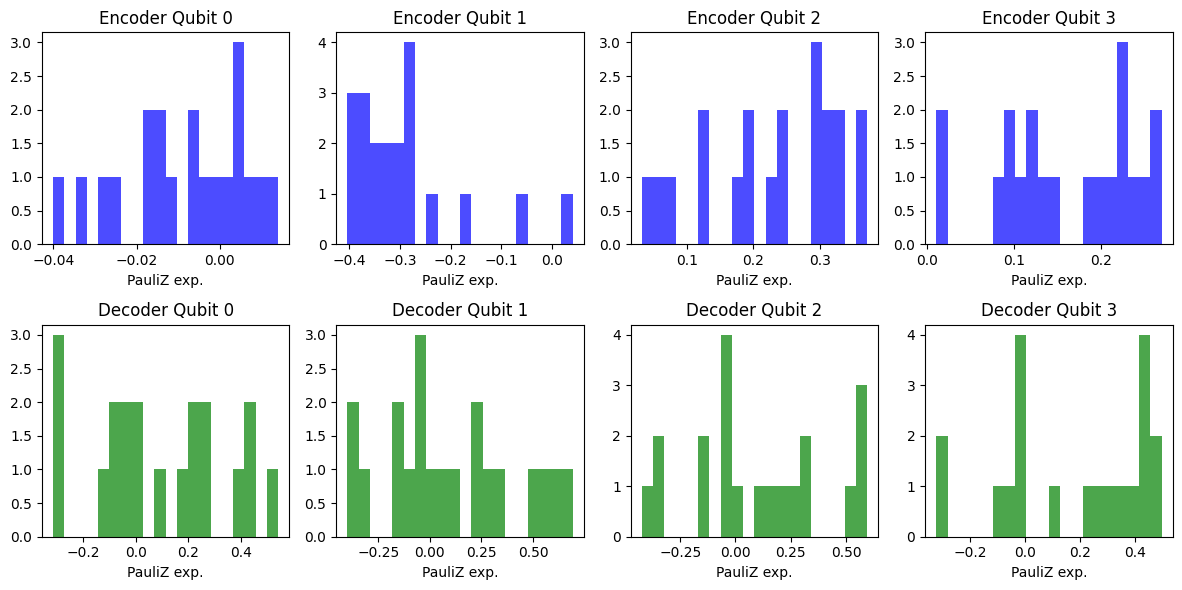

In [22]:
import matplotlib.pyplot as plt

# Wartości wszystkich kubitów enkodera
encoder_outputs = [sidekick_encoder(enc_params_trained, x) for x in X_test[:100]]
encoder_outputs = np.array(encoder_outputs)

# Wartości wszystkich kubitów dekodera
decoder_outputs = [sidekick_decoder(dec_params_trained, x) for x in X_test[:100]]
decoder_outputs = np.array(decoder_outputs)

plt.figure(figsize=(12, 6))
for i in range(encoder_outputs.shape[1]):
    plt.subplot(2, encoder_outputs.shape[1], i+1)
    plt.hist(encoder_outputs[:, i], bins=20, alpha=0.7, color='blue')
    plt.title(f'Encoder Qubit {i}')
    plt.xlabel('PauliZ exp.')

    plt.subplot(2, decoder_outputs.shape[1], encoder_outputs.shape[1]+i+1)
    plt.hist(decoder_outputs[:, i], bins=20, alpha=0.7, color='green')
    plt.title(f'Decoder Qubit {i}')
    plt.xlabel('PauliZ exp.')

plt.tight_layout()
plt.show()

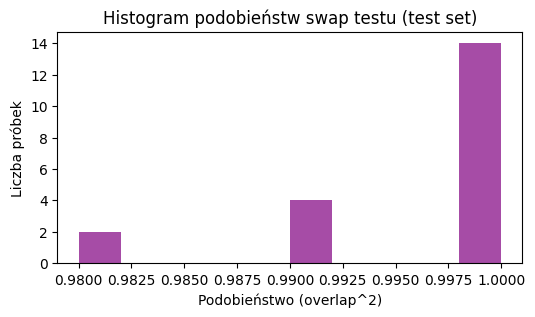

In [ ]:
n_samples = 20  # liczba próbek do sprawdzenia
swap_probs = []
swap_similarities = []

for x_noisy, x_clean in zip(X_test[:n_samples], X_test[:n_samples]):
    probs = swap_test_latent_qubits(enc_params_trained, dec_params_trained, x_noisy, x_clean, latent_indices)
    swap_probs.append(probs)
    similarity = 2 * probs[0] - 1
    swap_similarities.append(similarity)

swap_probs = np.array(swap_probs)
swap_similarities = np.array(swap_similarities)

plt.figure(figsize=(6,3))
plt.hist(swap_similarities, bins=10, color='purple', alpha=0.7)
plt.xlabel("Podobieństwo (overlap^2)")
plt.ylabel("Liczba próbek")
plt.title("Histogram podobieństw swap testu (test set)")
plt.show()